# Data Wrangling - Capstone 1

## Introduction

MIMIC-III is an open access database of medical records for over 40,000 de-identified patients. It includes a diverse set of electronic medical records (EMR): patient demographics, vitals, laboratory tests, procedures, medications, imaging reports, caregiver notes, and mortality data. The data corresponds to patients who were admitted to critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

In order to gain access to MIMIC-III, I first completed the Data or Specimens Only Research course and signed the user agreement. The MIMIC-III dataset is a relational database consisting of 26 tables. Here are some key specs of this dataset:

- Number of patients: 46,520
- Number of admissions: 58,976
- Number of planned admissions: 15,569
- Number of unplanned admissions: 43,407
- Number of readmissions within 30 days of discharge: 2,751
- Number of readmissions over 30 days of discharge: 7,065
- Number of single admissions: 33,591

## Import Libraries

# Import necessary libraries
import pandas as pd
import numpy as np
import datetime
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython import get_ipython
import scipy.stats as spstats

%run functions.ipynb
my_variables = set(dir())

In [22]:
# Import necessary libraries
import pandas as pd
import numpy as np
import datetime
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython import get_ipython
import scipy.stats as spstats

%run functions.ipynb
my_variables = set(dir())

Stored 'my_stop_words' (list)


## Load Data and functions

In [23]:
# load necessary tables from mimic database
df_adm = pd.read_csv('../mimic-iii-clinical-database-1.4/ADMISSIONS.csv')
df_icu = pd.read_csv('../mimic-iii-clinical-database-1.4/ICUSTAYS.csv')
df_pat = pd.read_csv('../mimic-iii-clinical-database-1.4/PATIENTS.csv')
df_icu = pd.read_csv('../mimic-iii-clinical-database-1.4/ICUSTAYS.csv')
df_ser = pd.read_csv('../mimic-iii-clinical-database-1.4/SERVICES.csv')
df_med = pd.read_csv('../mimic-iii-clinical-database-1.4/PRESCRIPTIONS.csv')
df_dicd = pd.read_csv('../mimic-iii-clinical-database-1.4/DIAGNOSES_ICD.csv')
df_dicdd = pd.read_csv(
    '../mimic-iii-clinical-database-1.4/D_ICD_DIAGNOSES.csv')
df_drg = pd.read_csv('../mimic-iii-clinical-database-1.4/DRGCODES.csv')
# read in doctor's discharge notes from NOTEEVENTS.csv
df_notes = pd.read_csv("../mimic-iii-clinical-database-1.4/NOTEEVENTS.csv")

## Remove planned and dead/organ donor admissions

In [17]:
df_adm = df_adm[df_adm['ADMISSION_TYPE'].isin(['EMERGENCY', 'URGENT'])
                & (df_adm['DIAGNOSIS'] != 'ORGAN DONOR ACCOUNT')
                & (df_adm['DISCHARGE_LOCATION'] != 'DEAD/EXPIRED')]
len(df_adm)

37811

## Create Target variable and counts

In [229]:
# convert string dates to date-formated dates
df_adm.ADMITTIME = convert_to_date(df_adm.ADMITTIME)
df_adm.DISCHTIME = convert_to_date(df_adm.DISCHTIME)
df_adm.DEATHTIME = convert_to_date(df_adm.DEATHTIME)
df_pat.DOB = convert_to_date(df_pat.DOB)

In [230]:
# sort by subject_ID and admission date
df_adm = df_adm.sort_values(['SUBJECT_ID', 'ADMITTIME'])
df_adm = df_adm.reset_index(drop=True)
# verify ADMITTIME is sorted in ascending order before inserting NEXT_ADMITTIME
df_adm.loc[df_adm.SUBJECT_ID == 124]

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
101,166,124,172461,2160-06-24 21:25:00,2160-07-15 15:10:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Private,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CVA,0,1
102,167,124,112906,2161-12-17 03:39:00,2161-12-24 15:35:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicare,NaN,CATHOLIC,MARRIED,WHITE,2161-12-16 18:57:00,2161-12-17 12:35:00,"CHEST PAIN,R/O MI",0,1


In [231]:
# add the next admission date and type for each subject using groupby
# you have to use groupby otherwise the dates will be from different subjects
df_adm['NEXT_ADMITTIME'] = df_adm.groupby('SUBJECT_ID').ADMITTIME.shift(-1)
# verify NEXT_ADMITTIME
df_adm.loc[
    df_adm.SUBJECT_ID == 124,
    ['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'NEXT_ADMITTIME']]

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,NEXT_ADMITTIME
101,124,172461,2160-06-24 21:25:00,2160-07-15 15:10:00,2161-12-17 03:39:00
102,124,112906,2161-12-17 03:39:00,2161-12-24 15:35:00,NaT


In [232]:
# calculate the number of days between discharge and next admission
df_adm['DAYS_NEXT_ADMIT'] = (df_adm.NEXT_ADMITTIME - df_adm.DISCHTIME
                             ).dt.total_seconds() / (24 * 60 * 60)

In [233]:
# verify DAYS_NEXT_ADMIT is calculated correctly: negative DAYS_NEXT_ADMIT are grouped with 'readmission within 30 days'
df_adm.loc[df_adm.SUBJECT_ID == 124, [
    'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'NEXT_ADMITTIME',
    'DAYS_NEXT_ADMIT', 'DIAGNOSIS'
]]

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,NEXT_ADMITTIME,DAYS_NEXT_ADMIT,DIAGNOSIS
101,124,172461,2160-06-24 21:25:00,2160-07-15 15:10:00,2161-12-17 03:39:00,519.520139,CVA
102,124,112906,2161-12-17 03:39:00,2161-12-24 15:35:00,NaT,NaN,"CHEST PAIN,R/O MI"


In [234]:
# creating target variable READMISSION_30DAYS: 'never readmitted'=0, 'readmitted<=30days'=1, 'readmitted>30days'=2
df_adm.loc[df_adm['DAYS_NEXT_ADMIT'].isna(), 'READMISSION_30DAYS'] = 2
df_adm.loc[df_adm['DAYS_NEXT_ADMIT'] < 31, 'READMISSION_30DAYS'] = 1
df_adm.loc[df_adm['DAYS_NEXT_ADMIT'] > 30, 'READMISSION_30DAYS'] = 0
print('READMISSION_30DAYS=1 (readmissions within 30 days): ',
      len(df_adm[df_adm['READMISSION_30DAYS'] == 1]))
print('READMISSION_30DAYS=0 (readmissions over 30 days): ',
      len(df_adm[df_adm['READMISSION_30DAYS'] == 0]))
print('READMISSION_30DAYS=2 (never readmitted): ',
      len(df_adm[df_adm['READMISSION_30DAYS'] == 2]))

READMISSION_30DAYS=1 (readmissions within 30 days):  2272
READMISSION_30DAYS=0 (readmissions over 30 days):  6249
READMISSION_30DAYS=2 (never readmitted):  29290


In [235]:
# create a master table that only contains the target variable and features and filtering for admissions with re-admissions only
# filter out 'never readmitted' READMISSION_30DAYS=2
master = df_adm.loc[df_adm['READMISSION_30DAYS']!=2,
        ['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME','DEATHTIME','NEXT_ADMITTIME',
         'DAYS_NEXT_ADMIT','READMISSION_30DAYS','DISCHARGE_LOCATION','INSURANCE',
         'MARITAL_STATUS', 'ETHNICITY','DIAGNOSIS','HOSPITAL_EXPIRE_FLAG']]

In [236]:
# check the distribution of READMISSION_30DAYS
total = len(master)
target1 = master.loc[master['READMISSION_30DAYS'] == 1, 'SUBJECT_ID'].count()
target0 = master.loc[master['READMISSION_30DAYS'] == 0, 'SUBJECT_ID'].count()

print('% READMISSION_30DAYS=1 (readmissions within 30 days): ',
      "{0:.1%}".format(target1 / total))
print('% READMISSION_30DAYS=0 (readmissions over 30 days): ',
      "{0:.1%}".format(target0 / total))

% READMISSION_30DAYS=1 (readmissions within 30 days):  26.7%
% READMISSION_30DAYS=0 (readmissions over 30 days):  73.3%


In [237]:
# verify target varible is calculated correctly
master[['SUBJECT_ID','ADMITTIME','NEXT_ADMITTIME','DAYS_NEXT_ADMIT','READMISSION_30DAYS']].head()

,SUBJECT_ID,ADMITTIME,NEXT_ADMITTIME,DAYS_NEXT_ADMIT,READMISSION_30DAYS
15,34,2186-07-18 16:46:00,2191-02-23 05:23:00,1678.557639,0.0
17,36,2131-04-30 07:15:00,2131-05-12 19:49:00,4.242361,1.0
35,68,2173-12-15 16:16:00,2174-01-04 22:21:00,1.160417,1.0
45,85,2162-03-02 14:04:00,2167-07-25 18:49:00,1963.231944,0.0
48,94,2176-02-25 16:49:00,2176-09-02 14:22:00,185.859028,0.0


## Feature Engineering

### Create feature AGE 

In [238]:
# add Date-Of-Birth to master table to facilitate Age calculation
#master.drop(['DOB_x','DOB_y'],axis=1,inplace=True)
master = pd.merge(master,
                  df_pat[['SUBJECT_ID', 'DOB','GENDER']],
                  on=['SUBJECT_ID'],
                  how='left')
# Age is calculated by subtracting DOB from ADMITTIME in units of year
master['AGE'] = (master.ADMITTIME.apply(lambda x: x.timestamp()) -
                 master.DOB.apply(lambda x: x.timestamp())
                 ).apply(lambda x: x / (24 * 60 * 60 * 365.25))
# verify Age is calculated correctly
master[['SUBJECT_ID', 'ADMITTIME', 'DOB', 'AGE']].head()

,SUBJECT_ID,ADMITTIME,DOB,AGE
0,34,2186-07-18 16:46:00,1886-07-18,299.996437
1,36,2131-04-30 07:15:00,2061-08-17,69.698295
2,68,2173-12-15 16:16:00,2132-02-29,41.795148
3,85,2162-03-02 14:04:00,2090-09-18,71.451297
4,94,2176-02-25 16:49:00,2101-09-20,74.433130


In [239]:
# replace 300 yrs-old, 1928 patients, with 91 which is median age of this group of patients
mask = master.AGE > 89
master.loc[mask, 'AGE'] = 91
# remove new born and children
master = master.loc[master['AGE'] > 18]

### Ethnicity Groups- reduce dimensions

In [240]:
# group different variation of the same ethnicity into one group
master['ETHNICITY_GRP'] = master.ETHNICITY.replace({
    'AMERICAN INDIAN/ALASKA NATIVE':
    'OTHER',
    'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE':
    'OTHER',
    'ASIAN - ASIAN INDIAN':
    'ASIAN',
    'ASIAN - CAMBODIAN':
    'ASIAN',
    'ASIAN - CHINESE':
    'ASIAN',
    'ASIAN - FILIPINO':
    'ASIAN',
    'ASIAN - KOREAN':
    'ASIAN',
    'ASIAN - OTHER':
    'ASIAN',
    'ASIAN - THAI':
    'ASIAN',
    'ASIAN - VIETNAMESE':
    'ASIAN',
    'BLACK/AFRICAN':
    'BLACK',
    'BLACK/AFRICAN AMERICAN':
    'BLACK',
    'BLACK/CAPE VERDEAN':
    'BLACK',
    'BLACK/HAITIAN':
    'BLACK',
    'CARIBBEAN ISLAND':
    'BLACK',
    'HISPANIC OR LATINO':
    'HISPANIC',
    'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)':
    'HISPANIC',
    'HISPANIC/LATINO - CUBAN':
    'HISPANIC',
    'HISPANIC/LATINO - DOMINICAN':
    'HISPANIC',
    'HISPANIC/LATINO - GUATEMALAN':
    'HISPANIC',
    'HISPANIC/LATINO - MEXICAN':
    'HISPANIC',
    'HISPANIC/LATINO - PUERTO RICAN':
    'HISPANIC',
    'HISPANIC/LATINO - SALVADORAN':
    'HISPANIC',
    'MIDDLE EASTERN':
    'WHITE',
    'MULTI RACE ETHNICITY':
    'OTHER',
    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER':
    'OTHER',
    'PATIENT DECLINED TO ANSWER':
    'OTHER',
    'UNABLE TO OBTAIN':
    'OTHER',
    'PORTUGUESE':
    'WHITE',
    'UNKNOWN/NOT SPECIFIED':
    'OTHER',
    'WHITE - BRAZILIAN':
    'WHITE',
    'WHITE - EASTERN EUROPEAN':
    'WHITE',
    'WHITE - OTHER EUROPEAN':
    'WHITE',
    'WHITE - RUSSIAN':
    'WHITE'
})

# count by ethnicity groups
master.groupby('ETHNICITY_GRP')['ETHNICITY_GRP'].agg('count')

ETHNICITY_GRP
ASIAN        173
BLACK       1564
HISPANIC     374
OTHER        410
WHITE       5992
Name: ETHNICITY_GRP, dtype: int64

### Create Current Service feature

In [241]:
# find last transfer time in order to find the final CURR_SERVICE that the patient was admitted under
max_trsf = df_ser.groupby('HADM_ID')['TRANSFERTIME'].agg('max')
last_trsf = pd.DataFrame(data=max_trsf,index=None)
last_trsf['HADM_ID']=last_trsf.index
last_trsf.columns=['TRANSFERTIME','HADM_ID']
last_trsf.reset_index(drop=True,inplace=True)
assert last_trsf.duplicated(['HADM_ID']).sum() == 0, 'Multiple current service per admission'

In [242]:
last_ser = pd.merge(last_trsf, df_ser[['SUBJECT_ID','HADM_ID','TRANSFERTIME','CURR_SERVICE']],
                    on=['HADM_ID','TRANSFERTIME'], how='left')
# adding CURR_SERVICE to master table; 9 admissions with missing CURR_SERVICE
master = pd.merge(master,last_ser[['SUBJECT_ID','HADM_ID','CURR_SERVICE']],
                  on=['SUBJECT_ID','HADM_ID'],how='left')

In [243]:
# reduce cardinality CURR_SERVICE
master['CURR_SERVICE'].replace({'ORTHO':'OTHER','GU':'OTHER','ENT':'OTHER','PSURG':'OTHER','GYN':'OTHER',
                                'OBS':'OTHER', np.nan:'OTHER'},inplace=True)

In [244]:
master.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME',
       'NEXT_ADMITTIME', 'DAYS_NEXT_ADMIT', 'READMISSION_30DAYS',
       'DISCHARGE_LOCATION', 'INSURANCE', 'MARITAL_STATUS', 'ETHNICITY',
       'DIAGNOSIS', 'HOSPITAL_EXPIRE_FLAG', 'DOB', 'GENDER', 'AGE',
       'ETHNICITY_GRP', 'CURR_SERVICE'],
      dtype='object')

### Create Number of prescriptions feature

In [245]:
#df_med = pd.read_csv('../mimic-iii-clinical-database-1.4/PRESCRIPTIONS.csv')
num_med = df_med.groupby(['SUBJECT_ID', 'HADM_ID'])['DRUG'].agg('count')
# groupby returns a Series, need to convert to dataframe
num_med_df = pd.DataFrame(data=num_med, index=None)
num_med_df['ID'] = num_med_df.index
num_med_df.reset_index(drop=True, inplace=True)
# SUBJECT_ID and HADM_ID were grouped as a tuple as a result of resetting index
# unpack index to get SUBJECT_ID and HADM_ID in seperate columns
sid_list = []
hid_list = []
for i in num_med_df['ID']:
    sid, hid = i
    sid_list.append(sid)
    hid_list.append(hid)
# add SUBJECT_ID and HADM_ID back to num_med_df as seperate columns
num_med_df['SUBJECT_ID'] = sid_list
num_med_df['HADM_ID'] = hid_list
# rename columns
num_med_df.columns = ['NUM_PRESCRIPTION', 'ID', 'SUBJECT_ID', 'HADM_ID']
# drop tuple index
num_med_df.drop(['ID'], axis=1, inplace=True)
# rearrange columns
num_med_df = num_med_df[['SUBJECT_ID', 'HADM_ID', 'NUM_PRESCRIPTION']]

In [246]:
# add NUM_PRESCRIPTION to master table
master = pd.merge(master,num_med_df[['SUBJECT_ID','HADM_ID','NUM_PRESCRIPTION']],on=['SUBJECT_ID','HADM_ID'],how='left')

In [247]:
# replace missing with 0's
master['NUM_PRESCRIPTION'].replace({np.nan: 0}, inplace=True)
np.isnan(master['NUM_PRESCRIPTION']).any()

False

### Create Length Of Stay Ratio (LOS_RATIO) feature

LOS_RATIO is defined as the sum of all ICU length of stay during a hospital stay divided by the total length of stay of that same hospital stay.

In [248]:
# replace LOS missing values in ICU_STAY table with 0; missing due to df_icu.OUTTIME missing which is most likely due to system integration mistakes
df_icu['LOS'].fillna(0, inplace=True)
# create ratio numerator by summing all ICU LOS per hospital admission
iculos = df_icu.groupby('HADM_ID')['LOS'].agg('sum').to_frame().reset_index()
# create ratio denominator by calculate total hospital length of stay i.e. Discharge Time - Admit Time
hlos = (master['DISCHTIME'] - master['ADMITTIME'])
master['HLOS'] = hlos.apply(lambda x: x / np.timedelta64(1, 'D'))
# add ICU LOS to master
master = pd.merge(master, iculos[['HADM_ID', 'LOS']], on=['HADM_ID'], how='left')

**Handle missing and unreasonable values before calculating feature**
* ICU LOS missing: hospital admissions (HADM_ID) cannot be found in ICU_STAYS table (drop 250 rows)
* ICU LOS greater than Hospital LOS (HLOS): ICU length of stay is longer than the hospital; use the one from ICU
* HLOS is negative: ADMITTIME is after DISCHTIME; use ICU LOS if exist

Keep the original values for LOS and HLOS by fixing the values and saving as new columns.

In [249]:
# drop rows with missing LOS_RATIO caused by missing LOS in ICU_STAYS
master.dropna(subset=['LOS'], inplace=True)

loslist=zip(master['LOS'],master['HLOS'])
hlos_cl=[]
for los, hlos in loslist:
# 1. ICU length of stay is greater than hospital length of stay
# 2. Hospital length of stay is negative because time of admission is after time of discharge
    if ((los>hlos)|(hlos<0)):
        hlos_cl.append(los)
    else:
        hlos_cl.append(hlos)
master['HLOS_CL']=hlos_cl

In [250]:
# calculate LOS_RATIO
master['LOS_RATIO'] = master.LOS / master.HLOS_CL

In [251]:
# check LOS_RATIO
master.loc[((master['LOS_RATIO']>1.0)|(master['LOS_RATIO']<0.0)),['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME','LOS','HLOS','HLOS_CL','LOS_RATIO','READMISSION_30DAYS']]

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,LOS,HLOS,HLOS_CL,LOS_RATIO,READMISSION_30DAYS


### Extract Diagnosis features from ICD9_CODE

In [252]:
# pull ICD9_CODE description from df_dicdd into df_dicd
df_dicd = pd.merge(df_dicd[['SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'ICD9_CODE']],
                   df_dicdd[['ICD9_CODE', 'SHORT_TITLE', 'LONG_TITLE']],
                   on=['ICD9_CODE'],
                   how='left')
# filter out admissions that are not in master
df_dicd = pd.merge(df_dicd,
                   master[['SUBJECT_ID', 'HADM_ID', 'READMISSION_30DAYS']],
                   on=['SUBJECT_ID', 'HADM_ID'],
                   how='left')
# filter out admissions with no ICD9_CODE
df_dicd = df_dicd.loc[~df_dicd['READMISSION_30DAYS'].isna()]

In [253]:
preprocess_text(df_dicd,'LONG_TITLE')

0    hypertensive chronic kidney disease  malignant...
1                      pneumonia  organism unspecified
2    chronic glomerulonephritis in diseases classif...
3                      chronic kidney disease  stage v
4                       other primary cardiomyopathies
5                                             acidosis
6                         systemic lupus erythematosus
7                                      hyperpotassemia
8                                             sciatica
9                         other iatrogenic hypotension
Name: LONG_TITLE_CL, dtype: object

In [254]:
# concatinate all of the ICD9_CODE descriptions into one big long string for creating wordcloud visualization
s = df_dicd['LONG_TITLE_CL']
text = s.str.cat(sep=' ')

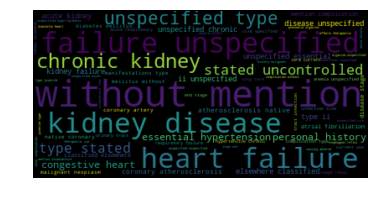

In [255]:
# create word cloud for diagnosis @ discharge
wordcloud = WordCloud(max_font_size=80,
                      max_words=200,
                      background_color="black").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [256]:
# filter for specific disease
#df_dicd.loc[df_dicd['longtitle_clean'].str.contains('septi|sepsi',regex=True)]

Base on the word cloud, I have manually identified 20 most frequently occurring diagnoses

In [257]:
# create a dictionary that contains the abbreviation and search-term for diagnosis
keys = [
    'KD', 'HP', 'PUL', 'UT', 'HIV', 'DB', 'MBD', 'TB', 'GA', 'HM', 'HEP', 'HO',
    'FR', 'TX', 'LA', 'AF', 'CB', 'PNE', 'HF', 'SP'
]
values = [
    'kidney', 'hypertension', 'pulmonary', 'urinary', 'human immunodeficiency',
    'diabe', 'mental|bipolar|depress', 'tuberculosis', 'gastr', 'hemorrhage',
    'hepatitis', 'hypotension', 'fracture', 'toxic', 'laceration',
    'atrial fibrillation', 'coronary bypass', 'pneumon', 'heart failure',
    'septi|sepsi'
]
diagnosis_dict = {keys[i]: values[i] for i in range(len(keys))}
print(str(diagnosis_dict))

{'KD': 'kidney', 'HP': 'hypertension', 'PUL': 'pulmonary', 'UT': 'urinary', 'HIV': 'human immunodeficiency', 'DB': 'diabe', 'MBD': 'mental|bipolar|depress', 'TB': 'tuberculosis', 'GA': 'gastr', 'HM': 'hemorrhage', 'HEP': 'hepatitis', 'HO': 'hypotension', 'FR': 'fracture', 'TX': 'toxic', 'LA': 'laceration', 'AF': 'atrial fibrillation', 'CB': 'coronary bypass', 'PNE': 'pneumon', 'HF': 'heart failure', 'SP': 'septi|sepsi'}


In [258]:
# generate binary variables for each diagnosis which will be inputs to the model as featuers
for k, v in diagnosis_dict.items():
    df_dicd[k] = df_dicd['LONG_TITLE_CL'].str.contains(v, regex=True, case=False).astype(int)
    df_md = df_dicd[['SUBJECT_ID', 'HADM_ID',
                     k]].groupby(['SUBJECT_ID',
                                  'HADM_ID']).agg('sum').reset_index()
    df_md[k] = df_md[k].apply(lambda x: 1.0 if x >= 1 else 0.0)
    master = pd.merge(master, df_md, on=['SUBJECT_ID', 'HADM_ID'], how='left')

### Create Comorbidity features

In [259]:
# clean up the description field in the Diagnosis Related Groups table
preprocess_text(df_drg,'DESCRIPTION')

0    traumatic stupor & coma  coma  1 hr age  17 wi...
1    major cardiovascular procedures with complicat...
2              neonate with other significant problems
3    specific cerebrovascular disorders except tran...
4              neonate with other significant problems
5    neonates  died or transferred to another acute...
6    cardiac valve & other major cardiothoracic pro...
7    other respiratory system diagnoses with compli...
8                coronary bypass with cardiac catheter
9    specific cerebrovascular disorders except tran...
Name: DESCRIPTION_CL, dtype: object

In [260]:
# create a dictionary that contains the abbreviation and search-term for the existence of comorbidity
keys = ['WMCC', 'WCC', 'WOCCMCC', 'WOMCC', 'WCCMCC']
values = [
    'wmcc',
    'wcc',
    'wnoncc|w/occ/mcc',
    'w/o mcc',
    'wcc/mcc',
]
comorbidity_dict = {keys[i]: values[i] for i in range(len(keys))}
print(str(comorbidity_dict))

{'WMCC': 'wmcc', 'WCC': 'wcc', 'WOCCMCC': 'wnoncc|w/occ/mcc', 'WOMCC': 'w/o mcc', 'WCCMCC': 'wcc/mcc'}


In [261]:
# generate binary variables for each diagnosis which will be inputs to the model as featuers
for k, v in comorbidity_dict.items():
    df_drg[k] = df_drg['DESCRIPTION_CL'].str.contains(v, regex=True, case=False).astype(int)
    df_r = df_drg[['SUBJECT_ID', 'HADM_ID',
                     k]].groupby(['SUBJECT_ID',
                                  'HADM_ID']).agg('sum').reset_index()
    df_r[k] = df_r[k].apply(lambda x: 1.0 if x >= 1 else 0.0)
    master = pd.merge(master, df_r, on=['SUBJECT_ID', 'HADM_ID'], how='left')

### Aggregate Severity and Mortality scores

In [262]:
# take the max DRG_SEVERITY and MORTALITY scores and use as input featuers to model
drg_serv_scr = df_drg[['SUBJECT_ID','HADM_ID','DRG_SEVERITY']].groupby(['SUBJECT_ID','HADM_ID']\
                ).agg('max').reset_index()
drg_mor_scr = df_drg[['SUBJECT_ID','HADM_ID','DRG_MORTALITY']].groupby(['SUBJECT_ID','HADM_ID']\
                ).agg('max').reset_index()
print('severity score: ', drg_serv_scr.DRG_SEVERITY.describe())
print('mortality score: ', drg_mor_scr.DRG_MORTALITY.describe())

severity score:  count    39395.000000
mean         2.957253
std          0.940749
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          4.000000
Name: DRG_SEVERITY, dtype: float64
mortality score:  count    39395.000000
mean         2.630613
std          1.119987
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          4.000000
Name: DRG_MORTALITY, dtype: float64


In [263]:
master = pd.merge(master,drg_serv_scr,on=['SUBJECT_ID', 'HADM_ID'],how='left')
master = pd.merge(master,drg_mor_scr,on=['SUBJECT_ID', 'HADM_ID'],how='left')
master['DRG_SEVERITY'].fillna(99,inplace=True)
master['DRG_MORTALITY'].fillna(99,inplace=True)
print(master['DRG_SEVERITY'].describe())
print(master['DRG_MORTALITY'].describe())

count    8308.000000
mean       31.944030
std        43.863105
min         1.000000
25%         3.000000
50%         4.000000
75%        99.000000
max        99.000000
Name: DRG_SEVERITY, dtype: float64
count    8308.000000
mean       31.724964
std        44.008427
min         1.000000
25%         3.000000
50%         4.000000
75%        99.000000
max        99.000000
Name: DRG_MORTALITY, dtype: float64


In [264]:
master.drop(['DRG_SEVERITY_x','DRG_SEVERITY_y','DRG_MORTALITY_x','DRG_MORTALITY_y'],axis=1,inplace=True)

KeyError: "['DRG_SEVERITY_x' 'DRG_SEVERITY_y' 'DRG_MORTALITY_x' 'DRG_MORTALITY_y'] not found in axis"

### Discharge Notes 

In [265]:
# filter for discharge summary only
df_notes_dis_sum = df_notes.loc[df_notes.CATEGORY == 'Discharge summary']
df_notes_dis_sum.shape

(59652, 11)

In [266]:
# some admissions have multiple discharge notes, I will only take the last one and assume that is the most recent one
df_notes_dis_sum_last = (df_notes_dis_sum.groupby(
    ['SUBJECT_ID', 'HADM_ID']).nth(-1)).reset_index()
assert df_notes_dis_sum_last.duplicated(['HADM_ID']).sum() == 0, 'Multiple discharge summaries per admission'

In [267]:
# 204 admissions have missing notes, 43 belongs to 'READMISSION_30DAYS'==1
# replace missing TEXT with a space 
master = pd.merge(master,
                        df_notes_dis_sum_last[['SUBJECT_ID','HADM_ID','TEXT']], 
                        on = ['SUBJECT_ID','HADM_ID'],
                        how = 'left')
assert len(master) == len(master), 'Number of rows increased'
master['TEXT'].replace(np.nan, ' ', inplace=True)

In [268]:
# preprocess and tokenize the text
preprocess_text(master,'TEXT')

0                                                     
1    admission date   [**2131 4 30**]              ...
2    admission date   [**2173 12 15**]             ...
3    admission date   [**2162 3 2**]              d...
4    admission date   [**2176 2 25**]              ...
5    admission date   [**2189 1 28**]              ...
6                                                     
7    admission date   [**2121 11 30**]             ...
8    admission date   [**2137 11 4**]              ...
9    admission date   [**2138 4 16**]              ...
Name: TEXT_CL, dtype: object

In [ ]:
#master.loc[master['TEXT_CL'].str.contains('cc'), ['TEXT', 'TEXT_CL']].iloc[1].iloc[1]

## Feature Scaling/Transformation

### Quartile Binning, Log Transformation and Boxcox Log Transformation

#### Quantile binning and Boxcox transforming for Age

Box Cox Log Transformation (AGE)

,SUBJECT_ID,HADM_ID,AGE,AGE_boxcox_lambda_opt
4,94,183686,74.433130,273.400892
5,105,161160,35.342112,97.593238
6,107,191941,62.884974,216.620968
7,107,182383,69.661351,249.503873
8,109,183350,20.245905,44.935202


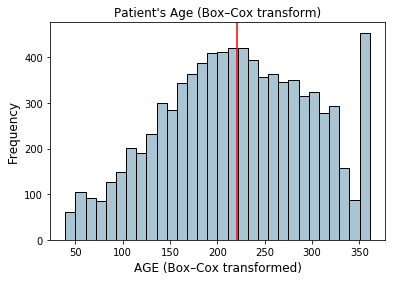

In [269]:
create_boxcox(dataset=master, column='AGE', title='Patient\'s Age (Box–Cox transform)')

master[['SUBJECT_ID', 'HADM_ID','AGE', 'AGE_boxcox_lambda_opt']].iloc[4:9]

Since the age distribution is approximately normal, we might not need to do log transformation. However, I am going to include the binned-version and log-transformed-version into the model separately to see which one yields better model performance.

#### Log transforming for Number of Presriptions

The number of prescription issued is highly skewed. Therefore, log transformation is needed to correct this issue. Binning would not help much in this case. Boxcox cannot be used because it does not take zero as input.

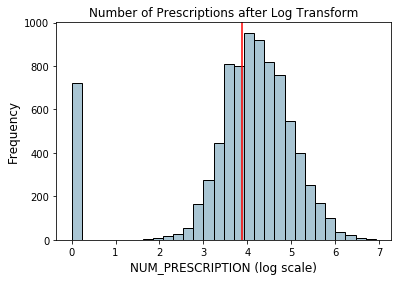

In [270]:
create_log_transform(dataset=master, column='NUM_PRESCRIPTION', title='Number of Prescriptions after Log Transform')

In [271]:
master[['SUBJECT_ID','HADM_ID','NUM_PRESCRIPTION', 'NUM_PRESCRIPTION_LOG']].iloc[4:10]

,SUBJECT_ID,HADM_ID,NUM_PRESCRIPTION,NUM_PRESCRIPTION_LOG
4,94,183686,55.0,4.025352
5,105,161160,40.0,3.713572
6,107,191941,14.0,2.708050
7,107,182383,46.0,3.850148
8,109,183350,162.0,5.093750
9,109,128755,38.0,3.663562


#### Log transformation for ICU LOS

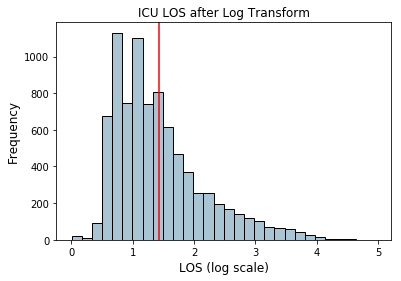

In [272]:
# perform log transformation for feature ICU LOS
create_log_transform(dataset=master, column='LOS', title='ICU LOS after Log Transform')

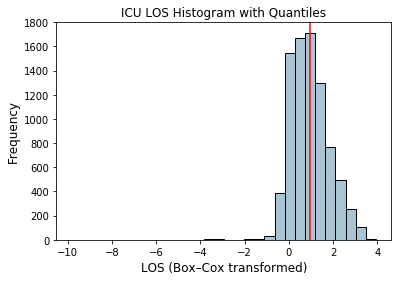

In [273]:
# perform boxcox log transformation for feature ICU LOS
create_boxcox(dataset=master, column='LOS', title='ICU LOS Histogram with Quantiles')

#### Log and Boxcox transformation for Hospital LOS (HLOS)

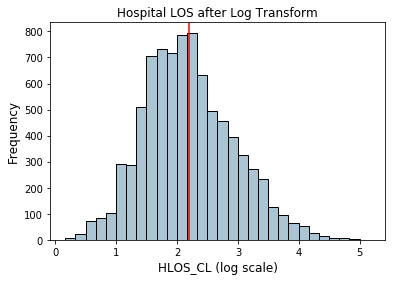

In [274]:
# perform log transformation for feature HLOS
create_log_transform(dataset=master, column='HLOS_CL', title='Hospital LOS after Log Transform')

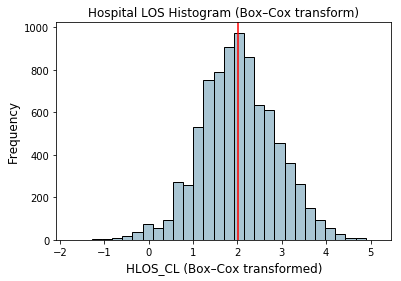

In [275]:
# perform boxcox log transformation for feature HLOS
create_boxcox(dataset=master, column='HLOS_CL', title='Hospital LOS Histogram (Box–Cox transform)')

#### Log and Boxcox transformation for LOS_RATIO

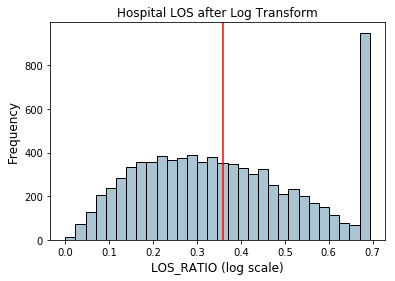

In [276]:
create_log_transform(dataset=master, column='LOS_RATIO', title='Hospital LOS after Log Transform')

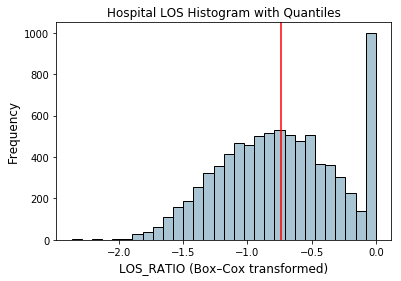

In [277]:
# perform boxcox log transformation for feature ICU LOS
create_boxcox(dataset=master, column='LOS_RATIO', title='Hospital LOS Histogram with Quantiles')

## Export master dataset as .csv file

In [278]:
# drop unnecessary columns
master.drop(['ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'NEXT_ADMITTIME', 'ETHNICITY',
             'DIAGNOSIS', 'HOSPITAL_EXPIRE_FLAG', 'DOB', 'DAYS_NEXT_ADMIT', 'HLOS'], axis=1, inplace=True)
# replace missing marital status with 'unknown'
master['MARITAL_STATUS'].fillna('unknown',inplace = True)
# replace nan in comborbidity variables with 0's
for col in master[['WMCC', 'WCC', 'WOCCMCC', 'WOMCC','WCCMCC']]:
    master[col].replace({np.nan: 0}, inplace=True)

In [279]:
# check for missing values
count_nan_in_df = master.isnull().sum()
print (count_nan_in_df)

SUBJECT_ID                     0
HADM_ID                        0
READMISSION_30DAYS             0
DISCHARGE_LOCATION             0
INSURANCE                      0
MARITAL_STATUS                 0
GENDER                         0
AGE                            0
ETHNICITY_GRP                  0
CURR_SERVICE                   0
NUM_PRESCRIPTION               0
LOS                            0
HLOS_CL                        0
LOS_RATIO                      0
KD                             0
HP                             0
PUL                            0
UT                             0
HIV                            0
DB                             0
MBD                            0
TB                             0
GA                             0
HM                             0
HEP                            0
HO                             0
FR                             0
TX                             0
LA                             0
AF                             0
CB        

In [280]:
# output master dataset as .csv file
master.to_csv(r'../data/master.csv')

In [281]:
master.columns

Index(['SUBJECT_ID', 'HADM_ID', 'READMISSION_30DAYS', 'DISCHARGE_LOCATION',
       'INSURANCE', 'MARITAL_STATUS', 'GENDER', 'AGE', 'ETHNICITY_GRP',
       'CURR_SERVICE', 'NUM_PRESCRIPTION', 'LOS', 'HLOS_CL', 'LOS_RATIO', 'KD',
       'HP', 'PUL', 'UT', 'HIV', 'DB', 'MBD', 'TB', 'GA', 'HM', 'HEP', 'HO',
       'FR', 'TX', 'LA', 'AF', 'CB', 'PNE', 'HF', 'SP', 'WMCC', 'WCC',
       'WOCCMCC', 'WOMCC', 'WCCMCC', 'DRG_SEVERITY', 'DRG_MORTALITY', 'TEXT',
       'TEXT_CL', 'AGE_boxcox_lambda_opt', 'NUM_PRESCRIPTION_LOG', 'LOS_LOG',
       'LOS_boxcox_lambda_opt', 'HLOS_CL_LOG', 'HLOS_CL_boxcox_lambda_opt',
       'LOS_RATIO_LOG', 'LOS_RATIO_boxcox_lambda_opt'],
      dtype='object')

In [ ]:
# clean up at the end by deleting all variables cached in memory
my_variables = list(set(dir()) - my_variables)
get_ipython().magic('%reset_selective -f [{}]'.format(','.join(my_variables)))